In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [3]:

# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

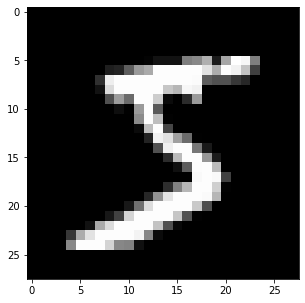

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
# define the NN architecture
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # 28 -> 14
        self.encoder1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, dilation=1),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # 14 -> 7
        self.encoder2 = torch.nn.Sequential(torch.nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1, dilation=1),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        ### decoder layers ###
        # 7 -> 14
        self.decoder1 = torch.nn.Sequential(torch.nn.ConvTranspose2d(16, 64, kernel_size=2, stride=2),
                                            torch.nn.ReLU())
        # 14 -> 28
        self.decoder2 = torch.nn.Sequential(torch.nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
                                            torch.nn.Sigmoid())

    def forward(self, x):
        ### encode ###
        x = self.encoder1(x)
        x = self.encoder2(x)
        
        ### decode ###
        x = self.decoder1(x)
        x = self.decoder2(x)

        return x


In [6]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder1): Sequential(
    (0): ConvTranspose2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (decoder2): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)


In [7]:
# specify loss function
criterion = torch.nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

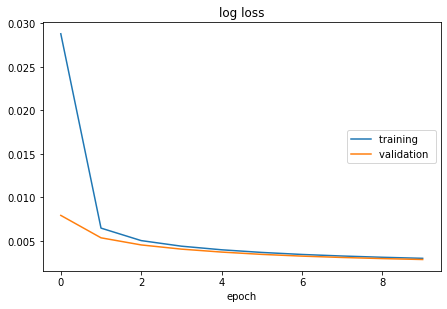

log loss
	training         	 (min:    0.003, max:    0.029, cur:    0.003)
	validation       	 (min:    0.003, max:    0.008, cur:    0.003)

[10/10]    {'log loss': 0.0030077460687607527, 'val_log loss': 0.002871826756745577}

Trained.


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# number of epochs to train the model
n_epochs = 10
liveloss = PlotLosses()

for epoch_id, epoch in enumerate(range(1, n_epochs+1)):
    # monitor training loss
    logs = {}

    for phase in ['train', 'test']:
        running_loss = 0.0
        for data in dataloaders[phase]:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            images = images.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            if phase == 'train':
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
            
            # update running training loss
            running_loss += loss.detach() * images.size(0)
            
        # print avg training statistics 
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if phase == 'test':
            prefix = 'val_' # that shit is hardcoded in PlotLosses - test called as "validation"
        if phase == 'train':
            prefix = ''     # that one too - "train" will be displayed only if label is empty
        logs[prefix + 'log loss'] = epoch_loss.item()
    liveloss.update(logs)
    liveloss.send()
    print(f"\n[{epoch_id+1}/{n_epochs}]    {logs}")
print("\nTrained.")

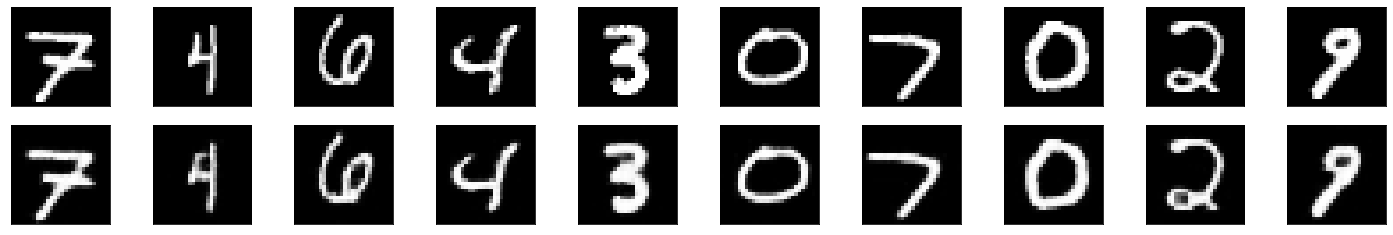

In [25]:
# obtain one batch of test images
dataiter = iter(test_loader)
dataiter.next()
dataiter.next()
images, labels = dataiter.next()
images = images.to(device)
# get sample outputs
output = model(images)
output = output.cpu()
# prep images for display
images = images.cpu()
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


In [21]:
len(test_loader.dataset)

10000